# Resnet50+FPN+SSD

自己从头到尾手写的第一个模型，在colab上测试一下效果

## 配置环境

In [1]:
!nvidia-smi

Tue Jul  4 14:37:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# 上传自己写的包后解压
# !unzip lastwork.zip

In [3]:
!rm lastwork.zip

rm: cannot remove 'lastwork.zip': No such file or directory


## 挂载google硬盘获取数据

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# !unzip drive/MyDrive/dl_detection.zip

> 花了2min52s来解压google drive中的数据

## 加载数据

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


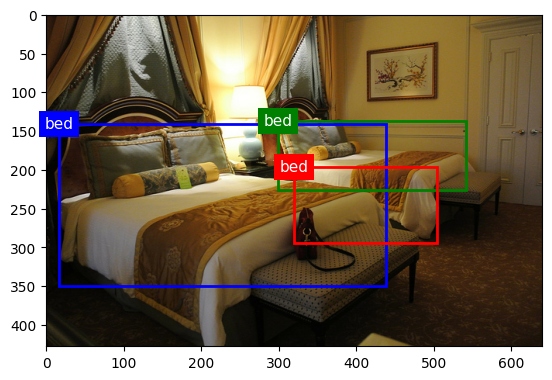

In [6]:
from utils.data import read_Cocodata_train, show_sample
Cocodata_train = read_Cocodata_train(is_transform = False)
show_sample(Cocodata_train, 0)

In [7]:
Cocodata_train = read_Cocodata_train(is_transform = True)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [8]:
Cocodata_train[0][0].shape, Cocodata_train[0][1].shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([3, 256, 256]), torch.Size([50, 5]))

## 定义模型

In [9]:
from mydet.backbone import Backbone
from mydet.neck import Neck
from mydet.head import Head
import torch

class R50_FPN_SSD(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Backbone(model='resnet50')
        self.neck = Neck()
        self.head = Head()

    def forward(self, X):
        backbone_out = self.backbone(X)
        neck_out = self.neck(backbone_out)
        head_out = self.head(neck_out) # anchor, cls, offset
        return head_out

## 设定训练参数

In [10]:
Cocodata_train

Dataset CocoDetection
    Number of datapoints: 33354
    Root location: ./dl_detection/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
           )
Target transform: <function target_transform at 0x7f40793d17e0>

In [11]:
# 将数据集取一小部分出来，用于训练
# Cocodata_train_small = torch.utils.data.Subset(Cocodata_train, range(0, 1000))

## 开始训练

In [12]:
from utils.device import try_gpu
from mydet.bbox.assigner import BBoxAssigner
device = try_gpu()
net = R50_FPN_SSD()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
num_epochs  = 5
batch_size = 128
iou_threshold = 0.5

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# 为锚框分配真实边界框
bbox_assigner = BBoxAssigner(
    device = device,
    iou_threshold = iou_threshold
)

In [14]:
train_dataloader = torch.utils.data.DataLoader(
    Cocodata_train,
    batch_size = batch_size,
    shuffle = True
)

### 训练函数

In [15]:
from utils.tools import Timer, Accumulator
from mydet.loss import calc_loss
from mydet.eval import cls_eval, bbox_eval

def train(net, train_dataloader, optimizer, num_epochs, device):
    net = net.to(device)
    timer = Timer()
    timer_per_batch = Timer()
    for epoch in range(num_epochs):
        # 训练精确度的和，训练精确度的和中的示例数
        # 绝对误差的和，绝对误差的和中的示例数
        metric = Accumulator(5)
        net.train()
        for features, target in train_dataloader:
            timer.start()
            timer_per_batch.start()
            optimizer.zero_grad()
            X, Y = features.to(device), target.to(device)

            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)

            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = bbox_assigner.multibox_target(anchors, Y)

            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels,
                        bbox_preds, bbox_labels,
                        bbox_masks)

            l.mean().backward() # 这里是默认对第一个维度做平均，即对batchsize做平均

            optimizer.step()

            metric.add(
                cls_eval(cls_preds, cls_labels),
                cls_labels.numel(),
                bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                bbox_labels.numel(),
                X.shape[0]
            )

            # 打印一下metric中的内容
            print(f"{epoch + 1:3d} epochs, {metric[4]:.1f} examples,"
                    f"{metric[0] / metric[1]:.2e} class acc,"
                    f"{metric[2] / metric[3]:.2e} bbox mae,"
                    f"{ X.shape[0] / timer_per_batch.stop():.1f} examples/sec on {str(device)}")

        cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]

        print(f"{epoch + 1:2d}/{num_epochs:2d} epoch, \
            class error = {cls_err}, bbox mae = {bbox_mae}")

    print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
    print(f'{len(train_dataloader.dataset) / timer.stop():.1f} examples/sec on '
        f'{str(device)}')

### 开始训练

In [16]:
train(
    net = net,
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    num_epochs = num_epochs,
    device = device
)

  1 epochs, 128.0 examples,2.71e-02 class acc,8.18e-02 bbox mae,21.9 examples/sec on cuda:0
  1 epochs, 256.0 examples,5.08e-01 class acc,8.26e-02 bbox mae,47.7 examples/sec on cuda:0
  1 epochs, 384.0 examples,6.69e-01 class acc,8.66e-02 bbox mae,37.9 examples/sec on cuda:0
  1 epochs, 512.0 examples,7.50e-01 class acc,9.37e-02 bbox mae,47.6 examples/sec on cuda:0
  1 epochs, 640.0 examples,7.98e-01 class acc,9.69e-02 bbox mae,48.0 examples/sec on cuda:0
  1 epochs, 768.0 examples,8.29e-01 class acc,1.02e-01 bbox mae,38.7 examples/sec on cuda:0
  1 epochs, 896.0 examples,8.51e-01 class acc,1.05e-01 bbox mae,48.3 examples/sec on cuda:0
  1 epochs, 1024.0 examples,8.49e-01 class acc,1.07e-01 bbox mae,47.8 examples/sec on cuda:0
  1 epochs, 1152.0 examples,8.25e-01 class acc,1.08e-01 bbox mae,43.2 examples/sec on cuda:0
  1 epochs, 1280.0 examples,8.42e-01 class acc,1.09e-01 bbox mae,47.7 examples/sec on cuda:0
  1 epochs, 1408.0 examples,8.55e-01 class acc,1.08e-01 bbox mae,45.0 example

In [17]:
# 将学习率手动调小十倍继续训练
optimizer.param_groups[0]['lr'] *= 0.1

In [18]:
train(
    net = net,
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    num_epochs = num_epochs,
    device = device
)

  1 epochs, 128.0 examples,9.91e-01 class acc,4.13e-02 bbox mae,46.9 examples/sec on cuda:0
  1 epochs, 256.0 examples,9.91e-01 class acc,4.05e-02 bbox mae,46.4 examples/sec on cuda:0
  1 epochs, 384.0 examples,9.91e-01 class acc,4.08e-02 bbox mae,47.6 examples/sec on cuda:0
  1 epochs, 512.0 examples,9.91e-01 class acc,4.03e-02 bbox mae,45.6 examples/sec on cuda:0
  1 epochs, 640.0 examples,9.91e-01 class acc,3.99e-02 bbox mae,46.6 examples/sec on cuda:0
  1 epochs, 768.0 examples,9.91e-01 class acc,3.94e-02 bbox mae,47.7 examples/sec on cuda:0
  1 epochs, 896.0 examples,9.91e-01 class acc,3.84e-02 bbox mae,40.0 examples/sec on cuda:0
  1 epochs, 1024.0 examples,9.91e-01 class acc,3.80e-02 bbox mae,46.2 examples/sec on cuda:0
  1 epochs, 1152.0 examples,9.91e-01 class acc,3.76e-02 bbox mae,47.1 examples/sec on cuda:0
  1 epochs, 1280.0 examples,9.91e-01 class acc,3.72e-02 bbox mae,38.7 examples/sec on cuda:0
  1 epochs, 1408.0 examples,9.91e-01 class acc,3.70e-02 bbox mae,47.1 example

KeyboardInterrupt: ignored

In [19]:
torch.save(net,'resnet50_fpn_ssd.pth')

In [22]:
net2 = torch.load('resnet50_fpn_ssd.pth',map_location=device)

In [23]:
net2

R50_FPN_SSD(
  (backbone): Backbone(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp